# Project 2
## Part 1. Building String Scoring Models
In this section, we will experiment with document classification -- in particular, whether a given 5-character string is in the English or French language, given two training documents (one in Eng, one in Fr).

We will go about this task by using Keras' LSTM (a recurrent neural network): we will begin by taking an English and a French document and, for each document, learn the conditional probability of a character following a certain substring. For example, Pr("p" | "trum") computes the probability that the character "p" follows the string "trum". Later, for a given 5-character string, we will compute log Pr(string | eng) and log Pr(string | french), and classify the document as English or French depending on whichever value is greater. For the finer details and the code, read on...

For this language detection experiment, we will be working with two files, eng.txt and frn.txt. These are two short documents pertaining to the topic of human rights. This data was downloaded from http://cloudmark.github.io/data/subset.zip , which is used in this blog, http://cloudmark.github.io/Language-Detection-Implemenation/. Note that the file frn.txt was further modified to remove some special characters so that the two documents have a common character set to work with.

Before moving on, it is also a good idea to review the Keras documentation and example on LSTM for text generation at https://keras.io/getting-started/sequential-model-guide/ and https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py, as the following code is inspired by the aformentioned example.

Let's first read both documents and lowercase them for convenience.

In [4]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

print ("Reading eng.txt and frn.txt into respective Strings and lowercasing...", end = "")
path_eng = './data/eng.txt'
path_frn = './data/frn.txt'
text_eng = open(path_eng).read().lower()
text_frn = open(path_frn).read().lower()

print("Done.")
print('English corpus String length:', len(text_eng))
print('French corpus String length:', len(text_frn))

Reading eng.txt and frn.txt into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009


Let's split each file into 80/20 learning/holdout subsets for training and testing.

In [5]:
print("Splitting the files into 80/20 training / holdout subsets...")
text_eng_breakpoint = int(len(text_eng) / 5) * 4
text_frn_breakpoint = int(len(text_frn) / 5) * 4
print("breakpoint indices for english and french documents, respectively: {}, {}".format(
        text_eng_breakpoint, text_frn_breakpoint))

train_eng = text_eng[:text_eng_breakpoint]
holdout_eng = text_eng[text_eng_breakpoint:]

train_frn = text_frn[:text_frn_breakpoint]
holdout_frn = text_frn[text_frn_breakpoint:]

print("\nSplit complete. Printing holdout_eng and holdout_frn to confirm...\n")

print(holdout_eng)
print(holdout_frn)

Splitting the files into 80/20 training / holdout subsets...
breakpoint indices for english and french documents, respectively: 8596, 9604

Split complete. Printing holdout_eng and holdout_frn to confirm...

n or out of wedlock, shall enjoy the same social protection. article 26 1. everyone has the right to education. education shall be free, at least in the elementary and fundamental stages. elementary education shall be compulsory. technical and professional education shall be made generally available and higher education shall be equally accessible to all on the basis of merit. 2. education shall be directed to the full development of the human personality and to the strengthening of respect for human rights and fundamental freedoms. it shall promote understanding, tolerance and friendship among all nations, racial or religious groups, and shall further the activities of the united nations for the maintenance of peace. 3. parents have a prior right to choose the kind of education th

We will soon proceed to train two LSTM models (size 128), one for eng.txt and one for frn.txt, on the learning datasets we just created. 

First, though, let's extract the set of unique characters that we'll be working with for both documents.

In [6]:
charset = sorted(list(set(text_eng + text_frn))) # extract all unique chars from english and french docs
print('Total no. of unique chars in both English and French text:', len(charset))
print('Charset:', charset)

print('Creating char-to-index and index-to-char dictionaries...', end="")
char_indices = dict((c, i) for i, c in enumerate(charset))
indices_char = dict((i, c) for i, c in enumerate(charset))
print('done.\n\nFor reference, the index-to-char dictionary is as follows:')
print(indices_char)

Total no. of unique chars in both English and French text: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y', 43: 'z'}


The two LSTM models will be trained separately for the English and French documents, to predict the next character given some previous substring. We will try this with the maximum length of previous substring set to 4. (each test string will be exactly 5 chars, which will be broken up into substring-nextchar. For example, a string like "trump" may be broken up into ""->"t", "t"->"r", "tr"->"u", "tru"->"m", and "trum"->"p". Thus the max. substring length is 4.)

Before training the LSTM, though, we will preprocess each of the two training documents.

Let's begin with the English training doc. We want to step through it and break it up into pairs: 1) previous substring, and 2) the character that immediately follows the substring.

In [7]:
print("Creating substring-nextchar pairs for English training doc...", end="")
maxlen = 4
step = 1

eng_substrs = []
eng_nextchars = []

# iterate thru training doc, advancing by 1 character each time,
# and create pair of substring and corresponding next character.
for j in range(0, len(train_eng) - maxlen, step):
    eng_substrs.append(train_eng[j: j + maxlen])
    eng_nextchars.append(train_eng[j + maxlen])

print("Done.")
print('Number of substring-nextchar pairs:', len(eng_substrs))
print("Here are the first twenty substring-nextchar pairs as a sanity check:")
for i in range(20):
    print("{} -> {}".format(eng_substrs[i], eng_nextchars[i]))

Creating substring-nextchar pairs for English training doc...Done.
Number of substring-nextchar pairs: 8592
Here are the first twenty substring-nextchar pairs as a sanity check:
univ -> e
nive -> r
iver -> s
vers -> a
ersa -> l
rsal ->  
sal  -> d
al d -> e
l de -> c
 dec -> l
decl -> a
ecla -> r
clar -> a
lara -> t
arat -> i
rati -> o
atio -> n
tion ->  
ion  -> o
on o -> f


As can be seen above, we have stepped through the training document one character at a time, and saved the substring-nextchar pair, where each substring is fixed at a length of 4.

Let's turn the above into a function for convenience...

In [8]:
def preprocess(training_doc, maxlen, step):
    print("Creating substring-nextchar pairs for training doc...", end="")
    substrs = []
    nextchars = []

    for j in range(0, len(training_doc) - maxlen, step):
        substrs.append(training_doc[j: j + maxlen])
        nextchars.append(training_doc[j + maxlen])
    print("Done.")
    print('Number of substring-nextchar pairs:', len(substrs))
    return substrs, nextchars

Now we can invoke the above function with both English and French training docs.

In [9]:
maxlen = 4
step = 1
eng_substrs, eng_nextchars = preprocess(train_eng, maxlen, step)
frn_substrs, frn_nextchars = preprocess(train_frn, maxlen, step)

Creating substring-nextchar pairs for training doc...Done.
Number of substring-nextchar pairs: 8592
Creating substring-nextchar pairs for training doc...Done.
Number of substring-nextchar pairs: 9600


Now that the preprocessing step is complete, let's build the X and Y matrices for each training document so that we can train the LSTM.

X represents a list of previous substrings of length maxlen, and will be in the form of a 3D nparray of dimensions I x J x K, where:
* I = total no. of substring-nextchar pairs for that training document
* J = maxlen
* K = len(charset), a.k.a. the total no. of unique chars.

More specifically:
* X[i] represents a single substring which will be of length J.
* X[i][j] represents a single character in substring X[i].
* X[i][j][k] is a boolean value, indicating whether the character represented by the value k is used in the substring X[i] at index position j.

Y represents a list of characters immediately following a previous substring, and will be in the form of a 2D nparray of dimensions I x K, where I and K are as defined above. More specifically:
* Y[i] represents a single character that corresponds to the previous substring X[i].
* Y[i][k] is a boolean value, indicating whether the character represented by the value k represents the character Y[i].

This may sound somewhat abstract, so let's first build the matrices and then we'll provide some illustrative examples.

In [10]:
def init_XY(substrs, nextchars, maxlen, charset, char_to_indices_dict):
    X = np.zeros((len(substrs), maxlen, len(charset)), dtype=np.bool)
    Y = np.zeros((len(substrs), len(charset)), dtype=np.bool)
    for i, seq in enumerate(substrs):
        
        for t in range(len(seq)):
            char = seq[t]
            X[i, t, char_to_indices_dict[char]] = 1
        Y[i, char_to_indices_dict[nextchars[i]]] = 1
    return X, Y

In [11]:
X_train_eng, Y_train_eng = init_XY(eng_substrs, eng_nextchars, maxlen, charset, char_indices)
X_train_frn, Y_train_frn = init_XY(frn_substrs, frn_nextchars, maxlen, charset, char_indices)

OK, so what exactly did we just build? Let's take a look at an illustrative example for the English document, by printing X[i] and Y[i] for some arbitrary i-value (e.g. i=2500), and see what the matrices actually look like.

In [12]:
i = 2500

print("\nX_train_eng[{}]:\n{}".format(i, X_train_eng[i]))
print("\nY_train_eng[{}]:\n{}".format(i, Y_train_eng[i]))


X_train_eng[2500]:
[[False False False False False False False False False False False False
  False False False False False False False False False  True False False
  False False False False False False False False False False False False
  False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False  True False False False False False False False False False
  False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
   True False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False

Note that X_train_eng[i] is a list containing 4 sublists (which makes sense since maxlen = 4 in our case), and each of those 4 sublists contains 44 boolean values (which again makes sense since charset = total no. of unique chars = 44 in our case).

Note that each sublist contains exactly one True element each. Grabbing the index position of each True element and converting that index to character via the indices_char dictionary (which we created previously) gives us the corresponding character of that substring.

Y_train_eng[i] can be decoded in the same way as above, except there is only one list of boolean variables (instead of 4 sublists) to worry about, since Y corresponds to a single character.

To wrap up, recall that X_train_eng[i] represents the previous substring, eng_substrs[i], while Y_train_eng[i] represents the corresponding next character, eng_nextchars[i].

Let's see if we can decode X_train_eng[i] and Y[i] into their original String form, and see if the decoded Strings match eng_substrs[i] and eng_nextchars[i], respectively. We'll write a short helper method or two to do this.

In [13]:
def decode_X(Xi, index_to_char_dict):
    ret = ''
    for j in range(len(Xi)):
#         print(Xi[j])
        ch_index = [k for k in range(len(Xi[j])) if Xi[j][k] == True]
#         print(ch_index)
        if len(ch_index) == 1:
            ret += index_to_char_dict[ch_index[0]]
    return ret

def decode_Y(Yi,index_to_char_dict):
    ret = ''
    ch_index = [k for k in range(len(Yi)) if Yi[k] == True]
#         print(ch_index)
    if len(ch_index) == 1:
#         ret += index_to_char_dict[ch_index[0]]
        return index_to_char_dict[ch_index[0]]
    return None
#     return ret


def check_match(i, X_train, Y_train, indices_char, substrs, nextchars):
    print("\nX_train[{}] decoded to substring:".format(i), end="")
    decoded_Xi = decode_X(X_train[i], indices_char)
    print(decoded_Xi)
    
    print("\nY_train[{}] decoded to character:".format(i), end="")
    decoded_Yi = decode_Y(Y_train[i], indices_char)
    print(decoded_Yi)
    
    print("\nChecking to see if the above strings match substrs[{}] and nextchars[{}]...".format(i,i))
    print("decoded_Xi, substrs[{}] = {}, {}".format(i, decoded_Xi, substrs[i]))
    print("decoded_Yi, nextchars[{}] = {}, {}".format(i, decoded_Yi, nextchars[i]))
    if decoded_Xi == substrs[i] and decoded_Yi == nextchars[i]:
        print("Match!")
    else:
        print("No match....")
    return decoded_Xi == substrs[i] and decoded_Yi == nextchars[i]

In [14]:
check_match(2500, X_train_eng, Y_train_eng, indices_char, eng_substrs, eng_nextchars)


X_train[2500] decoded to substring:dist

Y_train[2500] decoded to character:i

Checking to see if the above strings match substrs[2500] and nextchars[2500]...
decoded_Xi, substrs[2500] = dist, dist
decoded_Yi, nextchars[2500] = i, i
Match!


True

Just to double-check, we can try different values of i as well as for both the English and French document.

In [15]:
check_match(0, X_train_eng, Y_train_eng, indices_char, eng_substrs, eng_nextchars)
check_match(1000, X_train_eng, Y_train_eng, indices_char, eng_substrs, eng_nextchars)
check_match(-1, X_train_eng, Y_train_eng, indices_char, eng_substrs, eng_nextchars)

check_match(0, X_train_frn, Y_train_frn, indices_char, frn_substrs, frn_nextchars)
check_match(1000, X_train_frn, Y_train_frn, indices_char, frn_substrs, frn_nextchars)
check_match(-1, X_train_frn, Y_train_frn, indices_char, frn_substrs, frn_nextchars)


X_train[0] decoded to substring:univ

Y_train[0] decoded to character:e

Checking to see if the above strings match substrs[0] and nextchars[0]...
decoded_Xi, substrs[0] = univ, univ
decoded_Yi, nextchars[0] = e, e
Match!

X_train[1000] decoded to substring:al r

Y_train[1000] decoded to character:i

Checking to see if the above strings match substrs[1000] and nextchars[1000]...
decoded_Xi, substrs[1000] = al r, al r
decoded_Yi, nextchars[1000] = i, i
Match!

X_train[-1] decoded to substring:orn 

Y_train[-1] decoded to character:i

Checking to see if the above strings match substrs[-1] and nextchars[-1]...
decoded_Xi, substrs[-1] = orn , orn 
decoded_Yi, nextchars[-1] = i, i
Match!

X_train[0] decoded to substring:decl

Y_train[0] decoded to character:a

Checking to see if the above strings match substrs[0] and nextchars[0]...
decoded_Xi, substrs[0] = decl, decl
decoded_Yi, nextchars[0] = a, a
Match!

X_train[1000] decoded to substring:eur 

Y_train[1000] decoded to character:f

Chec

True

Now that we have encoded the previous substrings and their nextchars into X and Y, we can go ahead and build the LSTM model for each language. We will use LSTM size of 128, and try RMSprop with learning rate of 0.01 as the optimizer.

In [16]:
# build the model: a single LSTM for each document
def compile_model(maxlen, num_unique_chars):
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, num_unique_chars)))
    model.add(Dense(num_unique_chars))
    model.add(Activation('softmax'))

    optimizer = RMSprop(lr=0.01)
    # optimizer = 'adam'
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [17]:
# Build LSTM models
model_eng = compile_model(maxlen, len(charset))
model_frn = compile_model(maxlen, len(charset))

Now let's train the models with batch size 128 and 5 epochs.

In [18]:
print("Training English model...")
model_eng.fit(X_train_eng, Y_train_eng, batch_size=128, epochs=5)
print("Training French model...")
model_frn.fit(X_train_frn, Y_train_frn, batch_size=128, epochs=5)
print("Done.")

Training English model...
Epoch 1/5
8592/8592 [==============================] - 6s - loss: 2.6139 - acc: 0.2689     
Epoch 2/5
8592/8592 [==============================] - 3s - loss: 2.0449 - acc: 0.4259     - ETA: 0s - loss: 2.0721 - 
Epoch 3/5
8592/8592 [==============================] - 3s - loss: 1.7887 - acc: 0.4839     
Epoch 4/5
8592/8592 [==============================] - 3s - loss: 1.5979 - acc: 0.5320     
Epoch 5/5
8592/8592 [==============================] - 3s - loss: 1.4402 - acc: 0.5746     
Training French model...
Epoch 1/5
9600/9600 [==============================] - 5s - loss: 2.4843 - acc: 0.2893     
Epoch 2/5
9600/9600 [==============================] - 3s - loss: 1.9643 - acc: 0.4094     
Epoch 3/5
9600/9600 [==============================] - 3s - loss: 1.7452 - acc: 0.4674     
Epoch 4/5
9600/9600 [==============================] - 3s - loss: 1.5786 - acc: 0.5153     
Epoch 5/5
9600/9600 [==============================] - 3s - loss: 1.4495 - acc: 0.5453     
Do

Now that the models have been built, let's set them aside for a moment.

We will turn to the 20% holdout that we created at the beginning and generate test dataset. From each of the English holdout and French holdout text, we will randomly select 100 5-char substrings, to end up with 200 test strings in total. These are the x_test for evaluation: these will be used for evaluating whether they are in English or French. The y_test are 1 for English and 0 for French.

In [19]:
def generate_test_substrings(holdout_str, length, num_substrings, label):
    list_substr = []
    list_label = []
    for i in range(num_substrings):
        start_index = random.randint(0, len(holdout_str) - length - 1)
        list_substr.append(holdout_str[start_index: start_index + length])
        list_label.append(label)
    return list_substr, list_label

In [20]:
# generate 100 5-char strings and associated labels from the English holdout text
list_substr_eng, labels_eng = generate_test_substrings(holdout_eng, 5, 100, 1)
print(list_substr_eng, len(list_substr_eng))
print(labels_eng, len(labels_eng))

# generate 100 5-char strings and associated labels from the French holdout text
list_substr_frn, labels_frn = generate_test_substrings(holdout_frn, 5, 100, 0)
print(list_substr_frn, len(list_substr_frn))
print(labels_frn, len(labels_frn))

# Concatenate the above together into a single x_test and y_test
x_test = list_substr_eng + list_substr_frn
y_test = labels_eng + labels_frn

# length should be 200 for both x_test and y_test
print(x_test, len(x_test))
print(y_test, len(y_test))

['quire', 'entit', 'p amo', 'in th', 'ultin', 'f the', 'lemen', 'or ar', 'ryone', 'sis o', 'erpre', 'rther', 'p or ', 'ryone', 'l ord', 'evelo', 'he ex', '. 2. ', ' from', 'e in ', 'nt of', 'any a', ' to t', 'fic, ', 'ality', 'rts a', 'up or', 'one s', 'compu', 'ition', 'maint', ' arti', 'ed at', 'en. a', ' 1. e', 'o cas', 'te, g', 'er th', 'ryone', ' of t', ' prom', 't fre', 'emocr', 'their', 'ms ma', ' of m', 'le 30', 'rinci', ' of w', 'or ri', 'or pe', 'le. 2', 'produ', 'and f', 'ernat', 'rengt', 'roup ', 'chnic', 'he ba', 's.\n\n\x0c', ' in s', 'onal ', 'her e', 'tatio', 'ct on', ' is p', ' on t', 'an be', 'and i', 'hich ', 'enefi', 'ct fo', 'on sh', 'er in', 'es. e', 'o par', 'd nat', 'catio', '30 no', ' be e', 'no ca', 'll be', 'any a', 'ting ', 'onal ', 'pect ', 'equir', 'ealiz', ' educ', 'o par', 'h he ', 'ratio', 'ing, ', 'igher', 'ucati', 'he un', 'ing d', 'just ', 'l fur', 'or th'] 100
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

For each test string, we will compute the log likelihood of that string for each model. We use model.predict() and conceptually generate the predicted probability for each string. For example, if the test string is “trump” we use model.predict() to compute Pr(t|START), Pr(r|STARTt), Pr(u|STARTtr), … Pr(p|STARTtrum), take the log of the probabilities and add them up. So for each test string we will end up with two numbers (log(Pr(string|eng)), log(Pr(string|frn))). Whichever is greater is the predicted label for that string.

Let's try this on a single 5-character string for now. We'll choose an arbitrary English word, "trump", and see whether the models correctly predict it as such.

<b>Note:</b> the function below returns the predicted label (1 or 0) as well as a yhat_score value, which is the difference between log Pr(String|English) and log Pr(String|French). The reason for this is that we will soon perform calculation of ROC-AUC, and in doing so, typically y_hat takes on a real value, e.g. the probability from Logistic regression model or decision function value of SVM model. Here in this project, we will use (log Pr(String|English) - log Pr(String|French)) as our decision function.

In [21]:
def predict_lang(substr, maxlen, charset, char_indices, model_eng, model_frn, debug=True):
    sum_log_cond_prob_eng = 0
    sum_log_cond_prob_frn = 0

    for i in range(len(substr)):
        sequence = substr[:i] # previous substring
        next_ch = substr[i]   # next character
        if debug:
            print("sequence, next_ch: {}, {}".format(sequence, next_ch))

        # create matrix representation of prev. substring (similar to how we created X_train_eng for example)
        x = np.zeros((1, maxlen, len(charset)))
        reversed_seq = sequence[::-1]
        for t in range(len(reversed_seq)):
            char = reversed_seq[t]
            x[0, maxlen-1-t, char_indices[char]] = 1.

        # Use eng and frn models to predict the next character
        preds_eng = model_eng.predict(x, verbose=0)[0]
        preds_frn = model_frn.predict(x, verbose=0)[0]

        # get the index of the ground-truth next character
        tmp_index = char_indices[next_ch]

        # Look up the conditional probability of this next character from each predictive model
        cond_prob_eng = preds_eng[tmp_index]
        cond_prob_frn = preds_frn[tmp_index]
        if debug:
            print("Pr('{}'|'{}') (english): {}".format(next_ch, sequence, cond_prob_eng))
            print("Pr('{}'|'{}') (french): {}".format(next_ch, sequence, cond_prob_frn))

        # Take the log of the conditional probability
        log_cond_prob_eng = np.log(cond_prob_eng)
        log_cond_prob_frn = np.log(cond_prob_frn)
        if debug:
            print("log_cond_prob_eng, log_cond_prob_frn: {}, {}".format(log_cond_prob_eng,log_cond_prob_frn))

        # Add up the conditional probabilities for each model
        sum_log_cond_prob_eng += log_cond_prob_eng
        sum_log_cond_prob_frn += log_cond_prob_frn
        if debug:
            print()

    # Print out the sum of log conditional probability for illustrative purposes
    if debug:
        print("sum_log_cond_prob_eng: {}".format(sum_log_cond_prob_eng))
        print("sum_cond_prob_eng: {}".format(np.exp(sum_log_cond_prob_eng)))
        print("sum_log_cond_prob_frn: {}".format(sum_log_cond_prob_frn))
        print("sum_cond_prob_frn: {}".format(np.exp(sum_log_cond_prob_frn)))

    # Whichever cond. probability is greater wins.
    # ALso return log Pr(English) - Log Pr(French) for use with decision function. 
    if (sum_log_cond_prob_eng > sum_log_cond_prob_frn):
        if debug:
            print("This word is more likely to be English than French. Output label = 1, yhat_score = {}".format(
                    sum_log_cond_prob_eng-sum_log_cond_prob_frn))
        return 1, sum_log_cond_prob_eng-sum_log_cond_prob_frn
    else:
        if debug:
            print("This word is more likely to be French than English. Output label = 0, yhat_score = {}".format(
                sum_log_cond_prob_eng-sum_log_cond_prob_frn))
        return 0, sum_log_cond_prob_eng-sum_log_cond_prob_frn

In [22]:
predict_lang("trump", maxlen, charset, char_indices, model_eng, model_frn, debug=True)

sequence, next_ch: , t
Pr('t'|'') (english): 0.050287045538425446
Pr('t'|'') (french): 0.04826158285140991
log_cond_prob_eng, log_cond_prob_frn: -2.9900078773498535, -3.0311193466186523

sequence, next_ch: t, r
Pr('r'|'t') (english): 0.0723934918642044
Pr('r'|'t') (french): 0.09684941917657852
log_cond_prob_eng, log_cond_prob_frn: -2.625638961791992, -2.3345978260040283

sequence, next_ch: tr, u
Pr('u'|'tr') (english): 0.01291705947369337
Pr('u'|'tr') (french): 0.006963205058127642
log_cond_prob_eng, log_cond_prob_frn: -4.349206447601318, -4.96711540222168

sequence, next_ch: tru, m
Pr('m'|'tru') (english): 0.03236723691225052
Pr('m'|'tru') (french): 0.09749379754066467
log_cond_prob_eng, log_cond_prob_frn: -3.4306085109710693, -2.3279664516448975

sequence, next_ch: trum, p
Pr('p'|'trum') (english): 0.002839545952156186
Pr('p'|'trum') (french): 0.0015435511013492942
log_cond_prob_eng, log_cond_prob_frn: -5.864110946655273, -6.473669528961182

sum_log_cond_prob_eng: -19.259572744369507

(0, -0.12510418891906738)

The models correctly predicted "trump" as English, which is an encouraging sign. Let's try it on the entire test set...

In [23]:
y_scores = []
for i in range(len(x_test)):
    substr = x_test[i]
    ground_truth_label = y_test[i]
    pred_label, y_hat = predict_lang(substr, maxlen, charset, char_indices, model_eng, model_frn, debug=False)
    print(y_hat)
    y_scores.append(y_hat)
    print("pred_label and ground_truth_label for substring '{}': {}, {}".format(substr, pred_label, ground_truth_label))
    if pred_label == ground_truth_label:
        assert y_hat >= 0 if pred_label == 1 else y_hat < 0
        print("Correct prediction!")
    else:
        assert y_hat >= 0 if pred_label == 1 else y_hat < 0
        print("Wrong prediction.")

-8.1076548025
pred_label and ground_truth_label for substring 'quire': 0, 1
Wrong prediction.
0.413598775864
pred_label and ground_truth_label for substring 'entit': 1, 1
Correct prediction!
3.36594152451
pred_label and ground_truth_label for substring 'p amo': 1, 1
Correct prediction!
10.6641197801
pred_label and ground_truth_label for substring 'in th': 1, 1
Correct prediction!
5.65793228149
pred_label and ground_truth_label for substring 'ultin': 1, 1
Correct prediction!
13.8487857878
pred_label and ground_truth_label for substring 'f the': 1, 1
Correct prediction!
-3.54620365798
pred_label and ground_truth_label for substring 'lemen': 0, 1
Wrong prediction.
4.02814114094
pred_label and ground_truth_label for substring 'or ar': 1, 1
Correct prediction!
7.70317000523
pred_label and ground_truth_label for substring 'ryone': 1, 1
Correct prediction!
1.31964015961
pred_label and ground_truth_label for substring 'sis o': 1, 1
Correct prediction!
0.579923808575
pred_label and ground_truth

-0.890722692013
pred_label and ground_truth_label for substring 'o par': 0, 1
Wrong prediction.
14.1927173436
pred_label and ground_truth_label for substring 'h he ': 1, 1
Correct prediction!
-1.35389302671
pred_label and ground_truth_label for substring 'ratio': 0, 1
Wrong prediction.
8.36319262721
pred_label and ground_truth_label for substring 'ing, ': 1, 1
Correct prediction!
3.78781497478
pred_label and ground_truth_label for substring 'igher': 1, 1
Correct prediction!
-0.636903822422
pred_label and ground_truth_label for substring 'ucati': 0, 1
Wrong prediction.
2.61434930563
pred_label and ground_truth_label for substring 'he un': 1, 1
Correct prediction!
6.67683365941
pred_label and ground_truth_label for substring 'ing d': 1, 1
Correct prediction!
5.77496866882
pred_label and ground_truth_label for substring 'just ': 1, 1
Correct prediction!
3.65773782134
pred_label and ground_truth_label for substring 'l fur': 1, 1
Correct prediction!
9.28068441153
pred_label and ground_truth

-1.83871950302
pred_label and ground_truth_label for substring 'te, a': 0, 0
Correct prediction!
-5.25326919556
pred_label and ground_truth_label for substring 'sonna': 0, 0
Correct prediction!
-9.6921544075
pred_label and ground_truth_label for substring 'tifiq': 0, 0
Correct prediction!
-3.80472922325
pred_label and ground_truth_label for substring 're pu': 0, 0
Correct prediction!
-2.93411302567
pred_label and ground_truth_label for substring 't dan': 0, 0
Correct prediction!
-2.84139998257
pred_label and ground_truth_label for substring ', par': 0, 0
Correct prediction!
-5.13395878673
pred_label and ground_truth_label for substring 'ute d': 0, 0
Correct prediction!
-6.24156093597
pred_label and ground_truth_label for substring 'du re': 0, 0
Correct prediction!
-4.93359632418
pred_label and ground_truth_label for substring 't de ': 0, 0
Correct prediction!
-4.84153676033
pred_label and ground_truth_label for substring 'e leu': 0, 0
Correct prediction!
-0.883448243141
pred_label and 

Let's now use the y_scores that we obtained above as the decision function to compute our true positive rate, false positive rate, and ROC-AUC.

In [24]:
print(y_scores)

[-8.1076548025012016, 0.41359877586364746, 3.3659415245056152, 10.664119780063629, 5.6579322814941406, 13.848785787820816, -3.5462036579847336, 4.0281411409378052, 7.7031700052320957, 1.3196401596069336, 0.57992380857467651, 6.2299127578735352, 2.9190906882286072, 7.7031700052320957, 2.6858491897583008, -0.14163628220558167, 4.0640518665313721, 0.061252510640770197, 3.8128734827041626, 0.61704073846340179, 7.4132617115974426, 3.4592306017875671, 6.6085996627807617, -0.20867708697915077, 9.3162251114845276, 2.4978687912225723, 1.2089484930038452, 0.55725258588790894, -3.7482368946075439, -2.0682083759456873, -4.9515092372894287, 1.6979656349867582, 6.0046500563621521, 0.079467110335826874, 8.3747241292148829, 2.7018072605133057, -1.1901499191299081, 7.4928945600986481, 7.7031700052320957, 8.8499234765768051, 1.0727244913578033, 6.8800624907016754, 1.0987582206726074, 6.1714105606079102, 0.96215707063674927, 9.3253031820058823, -0.59014439582824707, -3.2726037502288818, 21.73982821404933

In [25]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:])
roc_auc = auc(fpr, tpr)

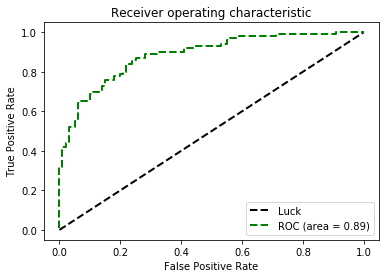

In [26]:
lw = 2 #line width

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck') #plot random guess, which would have ROC-AUC of 50%.

plt.plot(fpr, tpr, color='g', linestyle='--', label='ROC (area = {:.2f})'.format(roc_auc), lw=lw) #plot ROC

# Set the range of x-axis and y-axis for graphing purposes.
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=10)
plt.show()

The accuracy is not too shabby, esp. compared to a random guess which would yield 50% result. Here is a semi-logx version of the curve, for illustrative purposes:

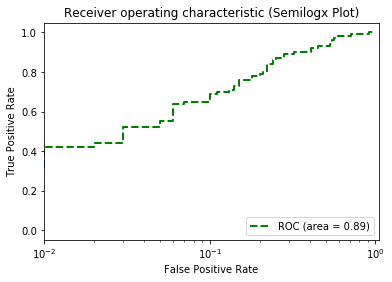

In [27]:
lw = 2
plt.semilogx(fpr, tpr, color='g', linestyle='--',
     label='ROC (area = {:.2f})'.format(roc_auc), lw=lw)
# plt.xticks(fpr, fpr)


# plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
#              label='Luck')

# plt.plot(fpr, tpr, color='g', linestyle='--',
#      label='ROC (area = {:.2f})'.format(roc_auc), lw=lw)

# Set the range of x-axis and y-axis for graphing purposes.
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (Semilogx Plot)')
plt.legend(loc="lower right", fontsize=10)
plt.show()

<b>So, let's recap what we have accomplished:</b>
* We built two LSTM models (English and French) capable of predicting the next character (and, in that process, also outputting the conditional probability of each character) given a previous substring.
* We trained each LSTM model on a sample English and a sample French document.
* We generated 200 instances of x_test, each of which is a substring of 5 characters, along with corresponding ground-truth labels y_test, each of which is 1 or 0 depending on whether the substring is in English or French.
* For each test substring, we used the two LSTM models to compute the log conditional probability that the substring would have been generated from an English or French document -- i.e. log Pr(String|English), log Pr(String|French), with the predicted label in accordance with which log probability was greater.
* We used [log Pr(String|English) - log Pr(String|French)] as the y_hat value for use in our decision function for purposes of computing fpr, trp, and auc-roc, resulting in the above score.

<b>Some discussions:</b>
1. Is this model good?
    * The predictive model significantly outperforms random guesses, so the model is good in that regard. But keep in mind that this was a binary classification task involving just two languages, and the train / test documents were each very short, with the English and French documents consisting of just 10746 and 12009 total character lengths, respectively. Future work may involve working with more than 2 languages, different model parameters, and / or longer training documents. Furthermore, other language detection models exist that may outperform this one.
2. What are at least three alternatives to language detection? What are the pros and cons of each approach?
    * Markov Models: Commonly used for tasks such as sequence labeling (e.g. Part-Of-Speech tagging) and spoken language identification, Markov Models are also used for written language detection. Markov Models generally combine transition probability and initial probability with the maximum likelihood estimation, i.e. computing the relative frequency of each transition or initial state in the training corpus of each language in question, in order to detect the language by computing the probabilities of observing certain character sequences. Certain implementations of this model has been found to result in very high accuracy rates (see, e.g. http://www.lsi.upc.edu/~nlp/papers/padro04a.pdf), while other implementations have had rather dismal performance (e.g. http://dl.acm.org/citation.cfm?id=2128415). In the latter study, for instance, Markov Models appear to be particularly sensitive to data sparseness and unequal language distribution in the training data.
    * N-gram based categorization: this model is based on the assumption that each language has some n-character sequence that appears often. The basic concept is to compare the frequency of n-grams in some unseen test data with those of training texts fo various languages, attributing the unseen text with the language with the most similar frequency rank. The system is small, fast, and tolerant of textual errors (misspellings and the like), but its performance depends heavily on the quality of the training set and the chosen value of n, and sometimes degrades on shorter documents (see, e.g. http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.53.9367).
    * Frequent-word based approach: A model is generated using a set number of most frequent words occurring in a given text for a language. The set number of frequent words may be fixed or dynamic, and the frequency value may be normalized (see, e.g. https://docs.google.com/viewer?url=patentimages.storage.googleapis.com/pdfs/US6216102.pdf). For any given test document of sufficient length, the document is classified as the language for which the greatest number of frequent words for that language are used in the document. While this approach is very simple and certain implementations of this approach has yielded extremely high accuracy in classification of documents (see, e.g. http://www.lrec-conf.org/proceedings/lrec2008/pdf/249_paper.pdf), by its nature this model isn't well-suited for classifying short phrases or individual words.
3. What are some possible ways to improve this model?
    * Training each of the LSTM models for a greater number of epochs, and/or using different parameters in constructing the models (e.g. size 256 instead of 128, using adam optimizer instead of RMSprop, etc.) - the expected result is that the accuracy of the model may be greater, at the cost of longer time to train.
    * Using GPUs for training would result in greatly improved efficiency in terms of reading and processing data sets and training the models; no change is expected in the accuracy of the models, however.
    * Using longer and/or greater number of training documents - this would increase the training instances of substring-to-nextchar pairs for each language, and is expected to make the LSTM models more robust and accurate.
    * Combining longer training documents (mentioned above) with variable step-sizes greater than 1. Recall that in our code above, the variable <code>step</code> was set to 1 during the document processing step, meaning that every possible substring-nextchar pair in the training document was converted into a training instance. We believe that using a larger step-size (e.g. step = 3) would skip over certain substring-nextchar pairs during preprocessing, thus possibly reducing overfitting.
    * Using longer maximum substring length - in our experiment above, the max. substring length was set at <code>maxlen</code> = 4 (since all the test strings were of length 5 each), but increasing <code>maxlen</code> might help the model generalize better to test strings of various lengths.

## Part 2. More Experiments to Improve Performance
In this part, we will explore a number of tweaks and modifications to our existing approach outlined in Part 1, and see whether and how they affect language detection results.

For conciseness, let's start by combining all the code in Part I into a single window and turning it into a customizable function called <code>train_predict</code> (minus some extraneous methods for interim testing, some of the print statements and such) that can be invoked with various different parameters. Note also that many of the variables such as model_eng and model_frn have been replaced with generic variables, and some methods have been further modified for more customizability.

In [28]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras import optimizers
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

def train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5):
    
    print ("Reading {} text and {} text into respective Strings and lowercasing...".format(lang1, lang2), end = "")
    text_1 = open(path_lang1).read().lower()
    text_2 = open(path_lang2).read().lower()

    print("Done.")
    print('{} corpus String length:'.format(lang1), len(text_1))
    print('{} corpus String length:'.format(lang2), len(text_2))
    print("Splitting the files into 80/20 training / holdout subsets...")
    text_1_breakpoint = int(len(text_1) / 5) * 4
    text_2_breakpoint = int(len(text_2) / 5) * 4

    train_1 = text_1[:text_1_breakpoint]
    holdout_1 = text_1[text_1_breakpoint:]

    train_2 = text_2[:text_2_breakpoint]
    holdout_2 = text_2[text_2_breakpoint:]

    charset = sorted(list(set(text_1 + text_2))) # extract all unique chars from english and french docs
    print('Total no. of unique chars in both documents:', len(charset))
    print('Charset:', charset)

    print('Creating char-to-index and index-to-char dictionaries...', end="")
    char_indices = dict((c, i) for i, c in enumerate(charset))
    indices_char = dict((i, c) for i, c in enumerate(charset))
    print('done.\n\nFor reference, the index-to-char dictionary is as follows:')
    print(indices_char)

    # Gather substring-nextchar pairs, where each substring has maximum length = maxlen.
    # If outerloop = True, gather all substrings of lengths 0 thru maxlen
    # else, only gather substrings of length maxlen
    def preprocess(training_doc, maxlen, step):
        print("Creating substring-nextchar pairs for training doc...", end="")
        substrs = []
        nextchars = []  
    
        for j in range(0, len(training_doc) - maxlen, step):
            substrs.append(training_doc[j: j + maxlen])
            nextchars.append(training_doc[j + maxlen])
        print("Done.")
        print('Number of substring-nextchar pairs:', len(substrs))
        return substrs, nextchars

#     maxlen = 4
#     step = 1
    lang1_substrs, lang1_nextchars = preprocess(train_1, maxlen, step)
    lang2_substrs, lang2_nextchars = preprocess(train_2, maxlen, step)

    def init_XY(substrs, nextchars, maxlen, charset, char_to_indices_dict):
        X = np.zeros((len(substrs), maxlen, len(charset)), dtype=np.bool)
        Y = np.zeros((len(substrs), len(charset)), dtype=np.bool)
        for i, seq in enumerate(substrs):

            for t in range(len(seq)):
                char = seq[t]
                X[i, t, char_to_indices_dict[char]] = 1
            Y[i, char_to_indices_dict[nextchars[i]]] = 1
        return X, Y

    X_train_1, Y_train_1 = init_XY(lang1_substrs, lang1_nextchars, maxlen, charset, char_indices)
    X_train_2, Y_train_2 = init_XY(lang2_substrs, lang2_nextchars, maxlen, charset, char_indices)

    # build the model: a single LSTM for each document
    def compile_model(maxlen, num_unique_chars):
        model = Sequential()
        model.add(LSTM(lstm_size, input_shape=(maxlen, num_unique_chars)))
        model.add(Dense(num_unique_chars))
        model.add(Activation('softmax'))
        
        if optimizer == 'rmsprop':
            opt = optimizers.RMSprop(lr=lr)
        elif optimizer == 'adam':
            opt = optimizers.Adam(lr=lr)
        elif optimizer == 'sgd':
            opt = optimizers.SGD(lr=lr)
        else:
            opt = optimizer

        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    # Build LSTM models
    model_1 = compile_model(maxlen, len(charset))
    model_2 = compile_model(maxlen, len(charset))

    print("Training {} model...".format(lang1))
    model_1.fit(X_train_1, Y_train_1, batch_size=batch_size, epochs=num_epoch)
    print("Training {} model...".format(lang2))
    model_2.fit(X_train_2, Y_train_2, batch_size=batch_size, epochs=num_epoch)
    print("Done.")

    def generate_test_substrings(holdout_str, length, num_substrings, label):
        list_substr = []
        list_label = []
        for i in range(num_substrings):
            start_index = random.randint(0, len(holdout_str) - length - 1)
            list_substr.append(holdout_str[start_index: start_index + length])
            list_label.append(label)
        return list_substr, list_label

    # generate 100 5-char strings and associated labels from the holdout text for lang1
    list_substr_1, labels_1 = generate_test_substrings(holdout_1, 5, 100, 1)

    # generate 100 5-char strings and associated labels from the holdout text for lang2
    list_substr_2, labels_2 = generate_test_substrings(holdout_2, 5, 100, 0)

    # Concatenate the above together into a single x_test and y_test
    x_test = list_substr_1 + list_substr_2
    y_test = labels_1 + labels_2

    def predict_lang(substr, maxlen, charset, char_indices, model_1, model_2):
        sum_log_cond_prob_1 = 0
        sum_log_cond_prob_2 = 0

        for i in range(len(substr)):
            sequence = substr[:i] # previous substring
            next_ch = substr[i]   # next character

            # create matrix representation of prev. substring (similar to how we created X_train_1 for example)
            x = np.zeros((1, maxlen, len(charset)))
            reversed_seq = sequence[::-1]
            for t in range(len(reversed_seq)):
                char = reversed_seq[t]
                x[0, maxlen-1-t, char_indices[char]] = 1.

            # Use eng and frn models to predict the next character
            preds_1 = model_1.predict(x, verbose=0)[0]
            preds_2 = model_2.predict(x, verbose=0)[0]

            # get the index of the ground-truth next character
            tmp_index = char_indices[next_ch]

            # Look up the conditional probability of this next character from each predictive model
            cond_prob_1 = preds_1[tmp_index]
            cond_prob_2 = preds_2[tmp_index]

            # Take the log of the conditional probability
            log_cond_prob_1 = np.log(cond_prob_1)
            log_cond_prob_2 = np.log(cond_prob_2)

            # Add up the conditional probabilities for each model
            sum_log_cond_prob_1 += log_cond_prob_1
            sum_log_cond_prob_2 += log_cond_prob_2

        # Whichever cond. probability is greater wins.
        # ALso return log Pr(English) - Log Pr(French) for use with decision function. 
        if (sum_log_cond_prob_1 > sum_log_cond_prob_2):
            return 1, sum_log_cond_prob_1-sum_log_cond_prob_2
        else:
            return 0, sum_log_cond_prob_1-sum_log_cond_prob_2

    y_scores = []
    for i in range(len(x_test)):
        substr = x_test[i]
        ground_truth_label = y_test[i]
        pred_label, y_hat = predict_lang(substr, maxlen, charset, char_indices, model_1, model_2)
        y_scores.append(y_hat)
        if pred_label == ground_truth_label:
            assert y_hat >= 0 if pred_label == 1 else y_hat < 0
        else:
            assert y_hat >= 0 if pred_label == 1 else y_hat < 0

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:])
    roc_auc = auc(fpr, tpr)

    lw = 2 #line width

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck') #plot random guess, which would have ROC-AUC of 50%.

    plt.plot(fpr, tpr, color='g', linestyle='--', label='ROC (area = {:.2f})'.format(roc_auc), lw=lw) #plot ROC

    # Set the range of x-axis and y-axis for graphing purposes.
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", fontsize=10)
    plt.show()

Now we can invoke the train_predict() method with various parameters we customize.

### Adjusting the models' parameters

Let's begin with some simple adjustments. In Part I, we used the RMSprop optimizer for training the models. Let's try the adam and SGD optimizers and see if there is any difference in the accuracy. All other parameters will remain the same.

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

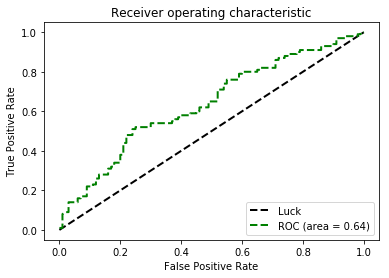

In [29]:
# Use SGD optimizer. Everything else is the same as Part I.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'sgd', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

As seen in the ROC curve, there is a significant decline in accuracy when we use SGD. Let's try the adam optimizer next...

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

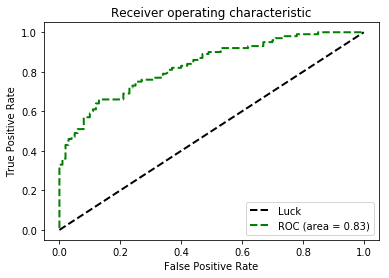

In [30]:
# Use Adam optimizer. Everything else is the same as Part I.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'adam', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

Now let's try each optimizer (rmsprop, sgd, adam) with epochs = 20, in that order.

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

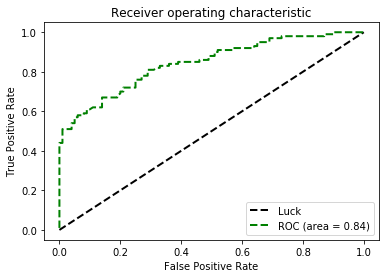

In [31]:
# RMSprop, epoch=20.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=20)

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

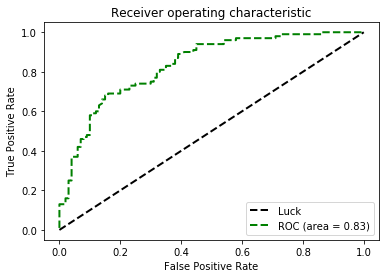

In [32]:
# SGD, epoch=20.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'sgd', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=20)

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

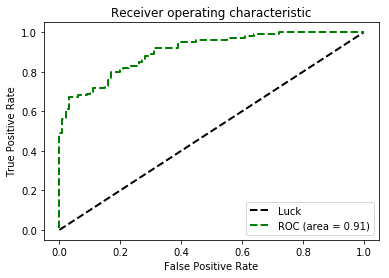

In [33]:
# Adam, epoch=20.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'adam', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=20)

As seen above, increasing the number of epochs had the greatest positive effect on SGD's performance.

This time, let's try varying the lstm size from 128 to 256, while keeping the number of epochs at 20.

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

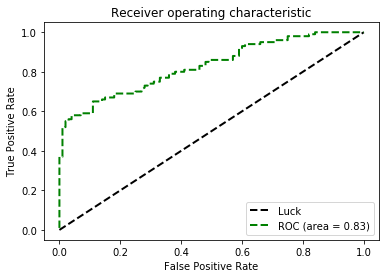

In [34]:
# RMSprop, epoch=20, lstm size = 256.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 256,
                  batch_size = 128,
                  num_epoch=20)

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

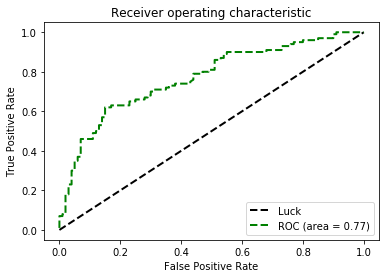

In [35]:
# SGD, epoch=20, lstm size = 256.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'sgd', lr = 0.01,
                  lstm_size = 256,
                  batch_size = 128,
                  num_epoch=20)

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

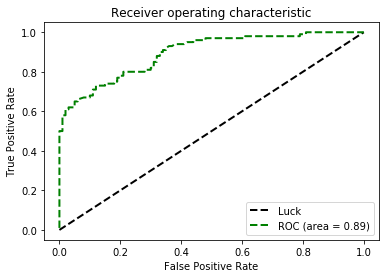

In [36]:
# Adam, epoch=20, lstm size = 256.
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'adam', lr = 0.01,
                  lstm_size = 256,
                  batch_size = 128,
                  num_epoch=20)

There doesn't seem to be a marked difference in accuracy this time around. It's possible that the size of the training / testing document is too small to show a significant difference in accuracy in the upper range.

In the next subsection, we'll try training the models on a couple of different languages other than English and French.

### Models for other languages

The data downloaded from http://cloudmark.github.io/data/subset.zip includes languages other than English and French, such as ltn.txt and dut.txt. We will see how our orignial models (from Part I) perform when detecting between some of these languages.

In this section, we will try English-Dutch, French-Dutch, English-Latin, French-Latin, and Dutch-Latin, in that order.

<b>English-Dutch:</b>

Reading English text and Dutch text into respective Strings and lowercasing...Done.
English corpus String length: 10746
Dutch corpus String length: 12888
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 46
Charset: ['\n', '\x0c', ' ', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 'ã']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: ',', 4: '-', 5: '.', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x'

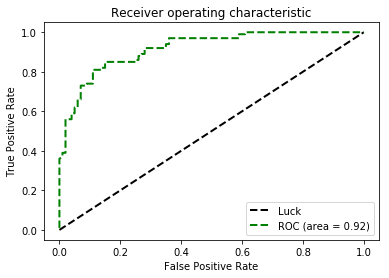

In [37]:
train_predict(lang1 = "English", lang2 = "Dutch", 
                  path_lang1='./data/eng.txt', path_lang2='./data/dut.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

<b>French-Dutch:</b>

Reading French text and Dutch text into respective Strings and lowercasing...Done.
French corpus String length: 12009
Dutch corpus String length: 12888
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 47
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 'ã']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ':', 18: ';', 19: 'a', 20: 'b', 21: 'c', 22: 'd', 23: 'e', 24: 'f', 25: 'g', 26: 'h', 27: 'i', 28: 'j', 29: 'k', 30: 'l', 31: 'm', 32: 'n', 33: 'o', 34: 'p', 35: 'q', 36: 'r', 37: 's', 38: 't', 39: 'u', 40: 'v', 41: 

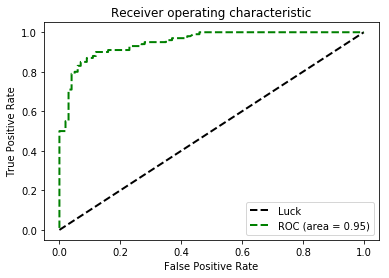

In [38]:
train_predict(lang1 = "French", lang2 = "Dutch", 
                  path_lang1='./data/frn.txt', path_lang2='./data/dut.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

<b>English-Latin:</b>

Reading English text and Latin text into respective Strings and lowercasing...Done.
English corpus String length: 10746
Latin corpus String length: 10065
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: ',', 4: '-', 5: '.', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y',

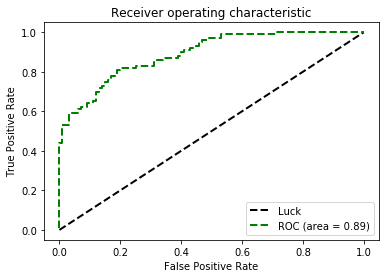

In [39]:
train_predict(lang1 = "English", lang2 = "Latin", 
                  path_lang1='./data/eng.txt', path_lang2='./data/ltn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

<b>French-Latin:</b>

Reading French text and Latin text into respective Strings and lowercasing...Done.
French corpus String length: 12009
Latin corpus String length: 10065
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 42
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ':', 18: ';', 19: 'a', 20: 'b', 21: 'c', 22: 'd', 23: 'e', 24: 'f', 25: 'g', 26: 'h', 27: 'i', 28: 'j', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'x', 41: 'y'}
Creating substring-n

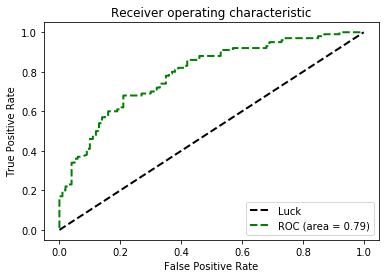

In [40]:
train_predict(lang1 = "French", lang2 = "Latin", 
                  path_lang1='./data/frn.txt', path_lang2='./data/ltn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

<b>Dutch-Latin:</b>

Reading Dutch text and Latin text into respective Strings and lowercasing...Done.
Dutch corpus String length: 12888
Latin corpus String length: 10065
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 46
Charset: ['\n', '\x0c', ' ', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 'ã']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: ',', 4: '-', 5: '.', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42

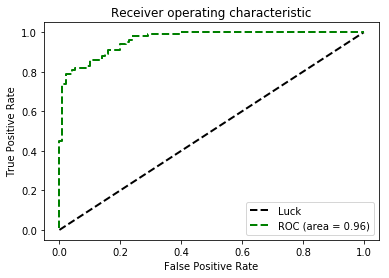

In [41]:
train_predict(lang1 = "Dutch", lang2 = "Latin", 
                  path_lang1='./data/dut.txt', path_lang2='./data/ltn.txt',
                  maxlen = 4, step = 1,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

Somewhat unsuprisingly, the type of languages have a measurable effect on how well the models are able to distinguish between them. The models show a high accuracy for some language pairs like Dutch - Latin, and comparably lower accuracy for others like French-Latin.

Could these results be refined and ultimately used to compute some kind of overall syntactic similarity score between two languages? Might be a topic for a future study.

In the next and final section, we will once again try to improve our accuracy over the original Part I models -- this time by making some modifications to the pre-processing step of the training documents.

### Additional preprocessing of the training documents

Thus far, we processed each training document by fixing the length of the substring at maxlen = 4. However, during the prediction stage, we attempted to compute the conditional probability of the next character given a previous substring of variable lengths (of length 0 thru length maxlen, inclusive). Perhaps it makes more sense for us to preprocess the training documents for variable substring lengths as well, and see if this improves results.

So, we will re-write the function <code>preprocess</code>, to include substrings of length 0 thru 4, inclusive. To do this, we will add an outer loop as seen below.

In [42]:
def preprocess(training_doc, maxlen, step):
    print("Creating substring-nextchar pairs for training doc...", end="")
    substrs = []
    nextchars = []

    for i in range(maxlen+1):
        for j in range(0, len(training_doc) - i, step):
            substrs.append(training_doc[j: j + i])
            nextchars.append(training_doc[j + i])
    print("Done.")
    print('Number of substring-nextchar pairs:', len(substrs))
    return substrs, nextchars

Let's try testing out the above function with the English document for illustration.

In [43]:
path_eng = './data/eng.txt'
text_eng = open(path_eng).read().lower()
text_eng_breakpoint = int(len(text_eng) / 5) * 4
train_eng = text_eng[:text_eng_breakpoint]
charset = sorted(list(set(text_eng))) # extract all unique chars from english doc
char_indices = dict((c, i) for i, c in enumerate(charset))
indices_char = dict((i, c) for i, c in enumerate(charset))



maxlen = 4
step = 1
eng_substrs, eng_nextchars = preprocess(train_eng, maxlen, step)

Creating substring-nextchar pairs for training doc...Done.
Number of substring-nextchar pairs: 42970


Above, we're iterating through the training document multiple times, and each time extracting a substring of different length, and forming substring-nextchar pair. Thus we see that the total number of substring-nextchar pair has increased to 42970 (in Part I, the number of pairs was only 8592).

Now that the preprocessing step is complete, let's try printing out some substring-nextchar pairs and compare the results with those in Part I.

In [44]:
print("\nLet's print some examples of substring-nextchar pairs for the various substring lengths...")
for i in range(5):
    print("Examples of pairs with substring length {}:".format(i))
    for j in range(i*10000, i*10000 + 20):
        print("{}->{}".format(eng_substrs[j], eng_nextchars[j]))


Let's print some examples of substring-nextchar pairs for the various substring lengths...
Examples of pairs with substring length 0:
->u
->n
->i
->v
->e
->r
->s
->a
->l
-> 
->d
->e
->c
->l
->a
->r
->a
->t
->i
->o
Examples of pairs with substring length 1:
e-> 
 ->f
f->o
o->r
r-> 
 ->t
t->h
h->e
e-> 
 ->f
f->u
u->l
l->l
l-> 
 ->r
r->e
e->a
a->l
l->i
i->z
Examples of pairs with substring length 2:
it->y
ty-> 
y ->o
 o->f
of-> 
f ->p
 p->e
pe->r
er->s
rs->o
so->n
on->.
n.-> 
. ->a
 a->r
ar->t
rt->i
ti->c
ic->l
cl->e
Examples of pairs with substring length 3:
 na->t
nat->i
ati->o
tio->n
ion->a
ona->l
nal-> 
al ->o
l o->r
 or-> 
or ->i
r i->n
 in->t
int->e
nte->r
ter->n
ern->a
rna->t
nat->i
ati->o
Examples of pairs with substring length 4:
endi->n
ndin->g
ding-> 
ing ->s
ng s->p
g sp->o
 spo->u
spou->s
pous->e
ouse->s
uses->.
ses.-> 
es. ->3
s. 3->.
. 3.-> 
 3. ->t
3. t->h
. th->e
 the-> 
the ->f


Note that we now have substrings of variable lengths, just like we wanted.

Due to the above, now we also need to modify the way that the X matrix is built for the training document. We will re-define X as follows:

X represents a list of previous substrings of various lengths (each substring length not to exceed maxlen), and will be in the form of a 3D nparray of dimensions I x J x K, where:
* I = total no. of substring-nextchar pairs for that training document
* J = maxlen
* K = len(charset), a.k.a. the total no. of unique chars.

More specifically:
* X[i] represents a single substring which will be of variable length, from length 0 to J inclusive.
* X[i][j] represents a single character in substring X[i]. This character may be empty.
* X[i][j][k] is a boolean value, indicating whether the character represented by the value k is used in the substring X[i] at index position j.

Let's go ahead and modify the method for initializing the matrices. Note that we don't need to make any changes into building matrix Y.

In [45]:
def init_XY(substrs, nextchars, maxlen, charset, char_to_indices_dict):
    X = np.zeros((len(substrs), maxlen, len(charset)), dtype=np.bool)
    Y = np.zeros((len(substrs), len(charset)), dtype=np.bool)
    for i, seq in enumerate(substrs):
        reversed_seq = seq[::-1]
        # Add the characters from right to left, such that the left part of the substring will be represented
        # as empty characters if the i-th substring length < maxlen.
        for t in range(len(reversed_seq)):
            char = reversed_seq[t]
            X[i, maxlen-1-t, char_to_indices_dict[char]] = 1
        Y[i, char_to_indices_dict[nextchars[i]]] = 1
    return X, Y

Unlike the original init_XY() method in Part I, this time we reverse each substring and add the characters from right to left to the matrix. What does this accomplish? See below:

In [46]:
X_train_eng, Y_train_eng = init_XY(eng_substrs, eng_nextchars, maxlen, charset, char_indices)
i = 25000
print("\nX_train_eng[{}]:\n{}".format(i, X_train_eng[i]))


X_train_eng[25000]:
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False  True False False False
  False False False False False False False False False False False False
  False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False  True False False Fals

Notice that the first two sublists consist of all False values, and only the last two sublists each contain a True value. Remember what these 4 sublists represent -- they represent each character of a given 4-character substring. A sublist with no True value means that that character is empty. So in this case, X_train_eng[i] represents a 2-character substring, because only the last 2 sublists each contain a True value.

Now let's check whether these modifications might improve the accuracy of the models. We will try it for all the different language pairs that we've tried thus far.

The full, modified code is below for reference:

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras import optimizers
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

def train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  preprocess_with_outerloop = True,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5):
    
    random.seed(0)
    print ("Reading {} text and {} text into respective Strings and lowercasing...".format(lang1, lang2), end = "")
    text_1 = open(path_lang1).read().lower()
    text_2 = open(path_lang2).read().lower()

    print("Done.")
    print('{} corpus String length:'.format(lang1), len(text_1))
    print('{} corpus String length:'.format(lang2), len(text_2))
    print("Splitting the files into 80/20 training / holdout subsets...")
    text_1_breakpoint = int(len(text_1) / 5) * 4
    text_2_breakpoint = int(len(text_2) / 5) * 4

    train_1 = text_1[:text_1_breakpoint]
    holdout_1 = text_1[text_1_breakpoint:]

    train_2 = text_2[:text_2_breakpoint]
    holdout_2 = text_2[text_2_breakpoint:]

    charset = sorted(list(set(text_1 + text_2))) # extract all unique chars from english and french docs
    print('Total no. of unique chars in both documents:', len(charset))
    print('Charset:', charset)

    print('Creating char-to-index and index-to-char dictionaries...', end="")
    char_indices = dict((c, i) for i, c in enumerate(charset))
    indices_char = dict((i, c) for i, c in enumerate(charset))
    print('done.\n\nFor reference, the index-to-char dictionary is as follows:')
    print(indices_char)

    # Gather substring-nextchar pairs, where each substring has maximum length = maxlen.
    # If outerloop = True, gather all substrings of lengths 0 thru maxlen
    # else, only gather substrings of length maxlen
    def preprocess(training_doc, maxlen, step, outerloop = True):
        print("Creating substring-nextchar pairs for training doc...", end="")
        substrs = []
        nextchars = []
        
        if outerloop:
            for i in range(maxlen+1):
                for j in range(0, len(training_doc) - i, step):
                    substrs.append(training_doc[j: j + i])
                    nextchars.append(training_doc[j + i])
        else:
            for j in range(0, len(training_doc) - maxlen, step):
                substrs.append(training_doc[j: j + maxlen])
                nextchars.append(training_doc[j + maxlen])
        print("Done.")
        print('Number of substring-nextchar pairs:', len(substrs))
        return substrs, nextchars

#     maxlen = 4
#     step = 1
    lang1_substrs, lang1_nextchars = preprocess(train_1, maxlen, step, preprocess_with_outerloop)
    lang2_substrs, lang2_nextchars = preprocess(train_2, maxlen, step, preprocess_with_outerloop)

    def init_XY(substrs, nextchars, maxlen, charset, char_to_indices_dict):
        X = np.zeros((len(substrs), maxlen, len(charset)), dtype=np.bool)
        Y = np.zeros((len(substrs), len(charset)), dtype=np.bool)
        for i, seq in enumerate(substrs):
            reversed_seq = seq[::-1]
            # Add the characters from right to left, such that the left part of the substring will be represented
            # as empty characters if the i-th substring length < maxlen.
            for t in range(len(reversed_seq)):
                char = reversed_seq[t]
                X[i, maxlen-1-t, char_to_indices_dict[char]] = 1
            Y[i, char_to_indices_dict[nextchars[i]]] = 1
        return X, Y

    X_train_1, Y_train_1 = init_XY(lang1_substrs, lang1_nextchars, maxlen, charset, char_indices)
    X_train_2, Y_train_2 = init_XY(lang2_substrs, lang2_nextchars, maxlen, charset, char_indices)

    # build the model: a single LSTM for each document
    def compile_model(maxlen, num_unique_chars):
        model = Sequential()
        model.add(LSTM(lstm_size, input_shape=(maxlen, num_unique_chars)))
        model.add(Dense(num_unique_chars))
        model.add(Activation('softmax'))
        
        if optimizer == 'rmsprop':
            opt = optimizers.RMSprop(lr=lr)
        elif optimizer == 'adam':
            opt = optimizers.Adam(lr=lr)
        elif optimizer == 'sgd':
            opt = optimizers.SGD(lr=lr)
        else:
            opt = optimizer
#         optimizer = RMSprop(lr=0.01)
        # optimizer = 'adam'
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    # Build LSTM models
    model_1 = compile_model(maxlen, len(charset))
    model_2 = compile_model(maxlen, len(charset))


    print("Training {} model...".format(lang1))
    model_1.fit(X_train_1, Y_train_1, batch_size=batch_size, epochs=num_epoch)
    print("Training {} model...".format(lang2))
    model_2.fit(X_train_2, Y_train_2, batch_size=batch_size, epochs=num_epoch)
    print("Done.")

    def generate_test_substrings(holdout_str, length, num_substrings, label):
        list_substr = []
        list_label = []
        for i in range(num_substrings):
            start_index = random.randint(0, len(holdout_str) - length - 1)
            list_substr.append(holdout_str[start_index: start_index + length])
            list_label.append(label)
        return list_substr, list_label

    # generate 100 5-char strings and associated labels from the holdout text for lang1
    list_substr_1, labels_1 = generate_test_substrings(holdout_1, 5, 100, 1)
#     print(list_substr_1, len(list_substr_1))
#     print(labels_1, len(labels_1))

    # generate 100 5-char strings and associated labels from the holdout text for lang2
    list_substr_2, labels_2 = generate_test_substrings(holdout_2, 5, 100, 0)
#     print(list_substr_2, len(list_substr_2))
#     print(labels_2, len(labels_2))

    # Concatenate the above together into a single x_test and y_test
    x_test = list_substr_1 + list_substr_2
    y_test = labels_1 + labels_2

#     print(x_test, len(x_test))
#     print(y_test, len(y_test))

    def predict_lang(substr, maxlen, charset, char_indices, model_1, model_2, debug=True):
        sum_log_cond_prob_1 = 0
        sum_log_cond_prob_2 = 0

        for i in range(len(substr)):
            sequence = substr[:i] # previous substring
            next_ch = substr[i]   # next character
#             if debug:
#                 print("sequence, next_ch: {}, {}".format(sequence, next_ch))

            # create matrix representation of prev. substring (similar to how we created X_train_1 for example)
            x = np.zeros((1, maxlen, len(charset)))
            reversed_seq = sequence[::-1]
            for t in range(len(reversed_seq)):
                char = reversed_seq[t]
                x[0, maxlen-1-t, char_indices[char]] = 1.

            # Use eng and frn models to predict the next character
            preds_1 = model_1.predict(x, verbose=0)[0]
            preds_2 = model_2.predict(x, verbose=0)[0]

            # get the index of the ground-truth next character
            tmp_index = char_indices[next_ch]

            # Look up the conditional probability of this next character from each predictive model
            cond_prob_1 = preds_1[tmp_index]
            cond_prob_2 = preds_2[tmp_index]
#             if debug:
#                 print("Pr('{}'|'{}') ({}): {}".format(next_ch, sequence, lang1, cond_prob_1))
#                 print("Pr('{}'|'{}') ({}): {}".format(next_ch, sequence, lang2, cond_prob_2))

            # Take the log of the conditional probability
            log_cond_prob_1 = np.log(cond_prob_1)
            log_cond_prob_2 = np.log(cond_prob_2)
#             if debug:
#                 print("log_cond_prob_eng, log_cond_prob_frn: {}, {}".format(log_cond_prob_eng,log_cond_prob_frn))

            # Add up the conditional probabilities for each model
            sum_log_cond_prob_1 += log_cond_prob_1
            sum_log_cond_prob_2 += log_cond_prob_2
#             if debug:
#                 print()

        # Print out the sum of log conditional probability for illustrative purposes
#         if debug:
#             print("sum_log_cond_prob_eng: {}".format(sum_log_cond_prob_eng))
#             print("sum_cond_prob_eng: {}".format(np.exp(sum_log_cond_prob_eng)))
#             print("sum_log_cond_prob_frn: {}".format(sum_log_cond_prob_frn))
#             print("sum_cond_prob_frn: {}".format(np.exp(sum_log_cond_prob_frn)))

        # Whichever cond. probability is greater wins.
        # ALso return log Pr(English) - Log Pr(French) for use with decision function. 
        if (sum_log_cond_prob_1 > sum_log_cond_prob_2):
#             if debug:
#                 print("This word is more likely to be {} than {}. Output label = 1, yhat_score = {}".format(
#                         lang1, lang2, sum_log_cond_prob_eng-sum_log_cond_prob_frn))
            return 1, sum_log_cond_prob_1-sum_log_cond_prob_2
        else:
#             if debug:
#                 print("This word is more likely to be {} than {}. Output label = 0, yhat_score = {}".format(
#                     lang2, lang1, sum_log_cond_prob_eng-sum_log_cond_prob_frn))
            return 0, sum_log_cond_prob_1-sum_log_cond_prob_2

    y_scores = []
    for i in range(len(x_test)):
        substr = x_test[i]
        ground_truth_label = y_test[i]
        pred_label, y_hat = predict_lang(substr, maxlen, charset, char_indices, model_1, model_2, debug=False)
#         print(y_hat)
        y_scores.append(y_hat)
#         print("pred_label and ground_truth_label for substring '{}': {}, {}".format(substr, pred_label, ground_truth_label))
        if pred_label == ground_truth_label:
            assert y_hat >= 0 if pred_label == 1 else y_hat < 0
#             print("Correct prediction!")
        else:
            assert y_hat >= 0 if pred_label == 1 else y_hat < 0
#             print("Wrong prediction.")

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:])
    roc_auc = auc(fpr, tpr)

    lw = 2 #line width

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck') #plot random guess, which would have ROC-AUC of 50%.

    plt.plot(fpr, tpr, color='g', linestyle='--', label='ROC (area = {:.2f})'.format(roc_auc), lw=lw) #plot ROC

    # Set the range of x-axis and y-axis for graphing purposes.
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", fontsize=10)
    plt.show()

Using TensorFlow backend.


We can invoke the above method with an extra parameter, <code>preprocess_with_outerloop</code> set to True.

Reading English text and French text into respective Strings and lowercasing...Done.
English corpus String length: 10746
French corpus String length: 12009
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y

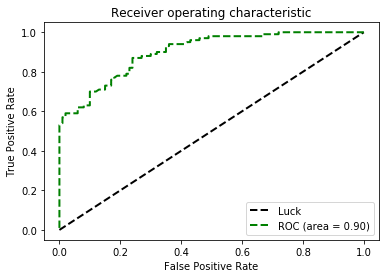

In [4]:
train_predict(lang1 = "English", lang2 = "French", 
                  path_lang1='./data/eng.txt', path_lang2='./data/frn.txt',
                  maxlen = 4, step = 1,
                  preprocess_with_outerloop = True,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

Reading English text and Dutch text into respective Strings and lowercasing...Done.
English corpus String length: 10746
Dutch corpus String length: 12888
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 46
Charset: ['\n', '\x0c', ' ', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 'ã']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: ',', 4: '-', 5: '.', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x'

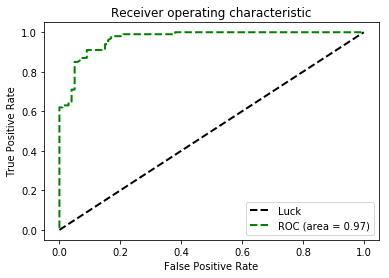

In [49]:
train_predict(lang1 = "English", lang2 = "Dutch", 
                  path_lang1='./data/eng.txt', path_lang2='./data/dut.txt',
                  maxlen = 4, step = 1,
                  preprocess_with_outerloop = True,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

Reading French text and Dutch text into respective Strings and lowercasing...Done.
French corpus String length: 12009
Dutch corpus String length: 12888
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 47
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 'ã']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ':', 18: ';', 19: 'a', 20: 'b', 21: 'c', 22: 'd', 23: 'e', 24: 'f', 25: 'g', 26: 'h', 27: 'i', 28: 'j', 29: 'k', 30: 'l', 31: 'm', 32: 'n', 33: 'o', 34: 'p', 35: 'q', 36: 'r', 37: 's', 38: 't', 39: 'u', 40: 'v', 41: 

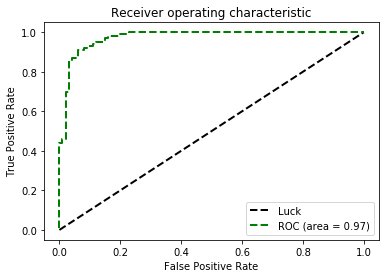

In [50]:
train_predict(lang1 = "French", lang2 = "Dutch", 
                  path_lang1='./data/frn.txt', path_lang2='./data/dut.txt',
                  maxlen = 4, step = 1,
                  preprocess_with_outerloop = True,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

Reading English text and Latin text into respective Strings and lowercasing...Done.
English corpus String length: 10746
Latin corpus String length: 10065
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 44
Charset: ['\n', '\x0c', ' ', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: ',', 4: '-', 5: '.', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42: 'y',

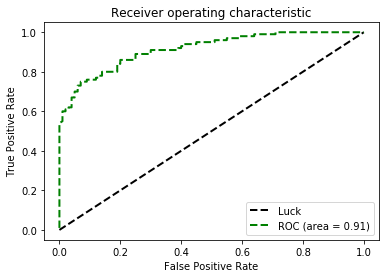

In [51]:
train_predict(lang1 = "English", lang2 = "Latin", 
                  path_lang1='./data/eng.txt', path_lang2='./data/ltn.txt',
                  maxlen = 4, step = 1,
                  preprocess_with_outerloop = True,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

Reading French text and Latin text into respective Strings and lowercasing...Done.
French corpus String length: 12009
Latin corpus String length: 10065
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 42
Charset: ['\n', '\x0c', ' ', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ':', 18: ';', 19: 'a', 20: 'b', 21: 'c', 22: 'd', 23: 'e', 24: 'f', 25: 'g', 26: 'h', 27: 'i', 28: 'j', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'x', 41: 'y'}
Creating substring-n

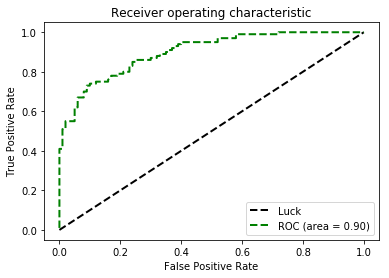

In [3]:
train_predict(lang1 = "French", lang2 = "Latin", 
                  path_lang1='./data/frn.txt', path_lang2='./data/ltn.txt',
                  maxlen = 4, step = 1,
                  preprocess_with_outerloop = True,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

Reading Dutch text and Latin text into respective Strings and lowercasing...Done.
Dutch corpus String length: 12888
Latin corpus String length: 10065
Splitting the files into 80/20 training / holdout subsets...
Total no. of unique chars in both documents: 46
Charset: ['\n', '\x0c', ' ', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 'ã']
Creating char-to-index and index-to-char dictionaries...done.

For reference, the index-to-char dictionary is as follows:
{0: '\n', 1: '\x0c', 2: ' ', 3: ',', 4: '-', 5: '.', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: ';', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'j', 28: 'k', 29: 'l', 30: 'm', 31: 'n', 32: 'o', 33: 'p', 34: 'q', 35: 'r', 36: 's', 37: 't', 38: 'u', 39: 'v', 40: 'w', 41: 'x', 42

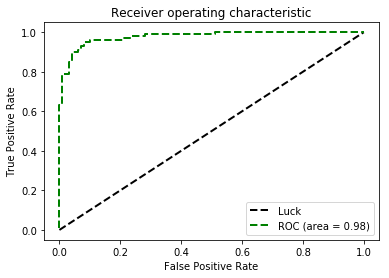

In [2]:
train_predict(lang1 = "Dutch", lang2 = "Latin", 
                  path_lang1='./data/dut.txt', path_lang2='./data/ltn.txt',
                  maxlen = 4, step = 1,
                  preprocess_with_outerloop = True,
                  optimizer = 'rmsprop', lr = 0.01,
                  lstm_size = 128,
                  batch_size = 128,
                  num_epoch=5)

<b>Compared with previous results in Part I and II, these results are noticeably better across the board!</b> The preprocessing modifications we implemented to save substrings of varying lengths in order to train the LSTMs have had a greater positive impact overall than any of the parameter changes we tried at the beginning of Part II.

## Conclusion

Although we will bring this session to a close for now, there is room for a lot more future experimentation and tweaks. For example, instead of working with pairs of languages (leading to binary decision), we could try to make predictions out of 3 or more languages at once. We could try working with longer and more robust documents, as well as more informal documents that contain misspellings, colloquialisms and so on. Also, instead of predicting the language of a fixed 5-character sequence, we could apply this model to predicting the language of entire articles, newspaper headlines, etc. While we have limited the scope of this experiment to those languages that contain more or less similar character sets, we might consider ways to expand it to other languages such as Japanese and Greek that have much more divergent characters.